In [7]:
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Model
from keras.datasets import cifar100
from keras.utils import to_categorical
from keras.optimizers import Adam
import matplotlib.pyplot as plt

# Models to do transfer learning on
from keras.applications.vgg16 import VGG16
from keras.applications.vgg19 import VGG19
from tensorflow.keras.applications import ResNet50
from keras.applications.inception_v3 import InceptionV3
from keras.applications.mobilenet_v2 import MobileNetV2


import numpy as np

# Load train and testdata

In [16]:
# Load and preprocess fashion mnist data for benchmark model
(train_images, train_labels), (test_images, test_labels) = cifar100.load_data()

In [17]:
print(    
    f'train_images shape: {np.shape(train_images)}\n'
    f'train_labels shape: {np.shape(train_labels)}\n'
    f'test_images shape: {np.shape(test_images)}\n'
    f'test_labels shape: {np.shape(test_labels)}\n'
)

train_images shape: (50000, 32, 32, 3)
train_labels shape: (50000, 1)
test_images shape: (10000, 32, 32, 3)
test_labels shape: (10000, 1)



# Benchmark model
Don't run this code (it takes a long time to run).

Performance: 52.6% on testdata.

In [18]:
# Reshape and normalize the images
train_images = train_images.astype('float32') / 255
test_images = test_images.astype('float32') / 255

In [19]:
def build_benchmark_model():
    model = Sequential([
        Conv2D(64, (3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
    
        Conv2D(128, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.4),
    
        Conv2D(256, (3, 3), padding='same', activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.5),
    
        Flatten(),
        Dense(1024, activation='relu'),
        Dropout(0.6),
        Dense(100, activation='softmax')  # 100 classes in CIFAR-100
    ])
    
    model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

In [20]:
benchmark_model = build_benchmark_model()

In [21]:
benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 16, 16, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 128)        0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 8, 8, 128)         0

In [18]:
benchmark_model.fit(train_images, train_labels, epochs=200, batch_size=256, verbose=1)

Epoch 1/200
196/196 [==============================] - 64s 322ms/step - loss: 4.5876 - accuracy: 0.0158
Epoch 2/200
196/196 [==============================] - 65s 332ms/step - loss: 4.3172 - accuracy: 0.0417
Epoch 3/200
196/196 [==============================] - 65s 333ms/step - loss: 4.1091 - accuracy: 0.0710
Epoch 4/200
196/196 [==============================] - 66s 337ms/step - loss: 3.9345 - accuracy: 0.1005
Epoch 5/200
196/196 [==============================] - 65s 334ms/step - loss: 3.8032 - accuracy: 0.1190
Epoch 6/200
196/196 [==============================] - 66s 336ms/step - loss: 3.6865 - accuracy: 0.1387
Epoch 7/200
196/196 [==============================] - 66s 334ms/step - loss: 3.5993 - accuracy: 0.1514
Epoch 8/200
196/196 [==============================] - 66s 336ms/step - loss: 3.5200 - accuracy: 0.1664
Epoch 9/200
196/196 [==============================] - 66s 338ms/step - loss: 3.4506 - accuracy: 0.1793
Epoch 10/200
196/196 [==============================] - 66s 337m

In [19]:
test_loss, test_acc = benchmark_model.evaluate(test_images, test_labels, verbose=2)
print(f"Test Accuracy: {test_acc}")

313/313 - 4s - loss: 1.8781 - accuracy: 0.5256 - 4s/epoch - 12ms/step
Test Accuracy: 0.525600016117096


# Task
Do transfer learning on the different models you can find in the import. If you have other models you want to try, go ahead!

The models should be trained on [CIFAR-100](https://www.cs.toronto.edu/~kriz/cifar.html) dataset.

Use imagenet weights for the models (if it dosen't exist, use something else that is not cifar100).

Do both fine tuning and feature extraction.

- Which models can you get to beat the testscore of the benchmark model?
- Which model can you get the highest accuracy on?


### VGG16

In [28]:
(train_images_x, train_labels_y), (test_images_x, test_labels_y) = cifar100.load_data()
train_images = tf.keras.applications.vgg16.preprocess_input(train_images_x)
test_images = tf.keras.applications.vgg16.preprocess_input(test_images_x)
train_labels = to_categorical(train_labels_y)
test_labels = to_categorical(test_labels_y)

In [30]:
# Load pre-trained VGG16 model without the top layer
def create_model(fine_tune=False, fine_tune_at=2):
    base_model = VGG16(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    if fine_tune:
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        # Freeze the base model
        base_model.trainable = False
    
    # Create a new model on top
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(100, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [38]:
model = create_model()
model.summary()

In [37]:
history = model.fit(train_images, train_labels, epochs=2, validation_split=0.2, verbose=1)

Epoch 1/50
  15/1563 [..............................] - ETA: 7:31 - loss: 19.5730 - accuracy: 0.0229

KeyboardInterrupt: 

In [ ]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(
    f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
    f'Loss: {round(test_loss, 2)}'    
)

### VGG19

In [57]:
(train_images_x, train_labels_y), (test_images_x, test_labels_y) = cifar100.load_data()
train_images = tf.keras.applications.vgg19.preprocess_input(train_images_x)
test_images = tf.keras.applications.vgg19.preprocess_input(test_images_x)
train_labels = to_categorical(train_labels_y)
test_labels = to_categorical(test_labels_y)

In [58]:
# Load pre-trained VGG16 model without the top layer
def create_model(fine_tune=False, fine_tune_at=2):
    base_model = VGG19(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    if fine_tune:
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        # Freeze the base model
        base_model.trainable = False
    
    # Create a new model on top
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(100, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [59]:
model = create_model()
model.summary()

Model: "model_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_26 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 vgg19 (Functional)          (None, 1, 1, 512)         20024384  
                                                                 
 flatten_13 (Flatten)        (None, 512)               0         
                                                                 
 dense_26 (Dense)            (None, 64)                32832     
                                                                 
 dense_27 (Dense)            (None, 100)               6500      
                                                                 
Total params: 20,063,716
Trainable params: 39,332
Non-trainable params: 20,024,384
_________________________________________________________________


In [46]:
history = model.fit(train_images, train_labels, epochs=2, validation_split=0.2, verbose=1)

Epoch 1/2
  25/1250 [..............................] - ETA: 7:16 - loss: 16.4245 - accuracy: 0.0100

KeyboardInterrupt: 

In [48]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

 50/313 [===>..........................] - ETA: 2:13 - loss: 9.4747 - accuracy: 0.0237

KeyboardInterrupt: 

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(
    f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
    f'Loss: {round(test_loss, 2)}'    
)

### MobileNetV2

In [66]:
(train_images_x, train_labels_y), (test_images_x, test_labels_y) = cifar100.load_data()
train_images = tf.keras.applications.mobilenet_v2.preprocess_input(train_images_x)
test_images = tf.keras.applications.mobilenet_v2.preprocess_input(test_images_x)
train_labels = to_categorical(train_labels_y)
test_labels = to_categorical(test_labels_y)

In [67]:
# Load pre-trained VGG16 model without the top layer
def create_model(fine_tune=False, fine_tune_at=2):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(32, 32, 3))

    if fine_tune:
        # Freeze all the layers before the `fine_tune_at` layer
        for layer in base_model.layers[:fine_tune_at]:
            layer.trainable = False
    else:
        # Freeze the base model
        base_model.trainable = False
    
    # Create a new model on top
    inputs = tf.keras.Input(shape=(32, 32, 3))
    x = base_model(inputs)
    x = Flatten()(x)
    x = Dense(64, activation='relu')(x)
    outputs = Dense(100, activation='softmax')(x)
    model = Model(inputs, outputs)
    
    # Compile and train the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [68]:
model = create_model()
model.summary()

Model: "model_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_30 (InputLayer)       [(None, 32, 32, 3)]       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1, 1, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_14 (Flatten)        (None, 1280)              0         
                                                                 
 dense_28 (Dense)            (None, 64)                81984     
                                                                 
 dense_29 (Dense)            (None, 100)               6500      
                                                                 
Total params: 2,346,468
Trainable params: 88,484
Non-trainable params: 2,257,984
___________________________________________

In [69]:
history = model.fit(train_images, train_labels, epochs=2, validation_split=0.2, verbose=1)

Epoch 1/2
1250/1250 [==============================] - 83s 61ms/step - loss: 4.3819 - accuracy: 0.0503 - val_loss: 4.2340 - val_accuracy: 0.0682
Epoch 2/2
1250/1250 [==============================] - 72s 58ms/step - loss: 4.1170 - accuracy: 0.0860 - val_loss: 4.1310 - val_accuracy: 0.0851


In [70]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels, verbose=1)

313/313 [==============================] - 13s 42ms/step - loss: 4.1252 - accuracy: 0.0864


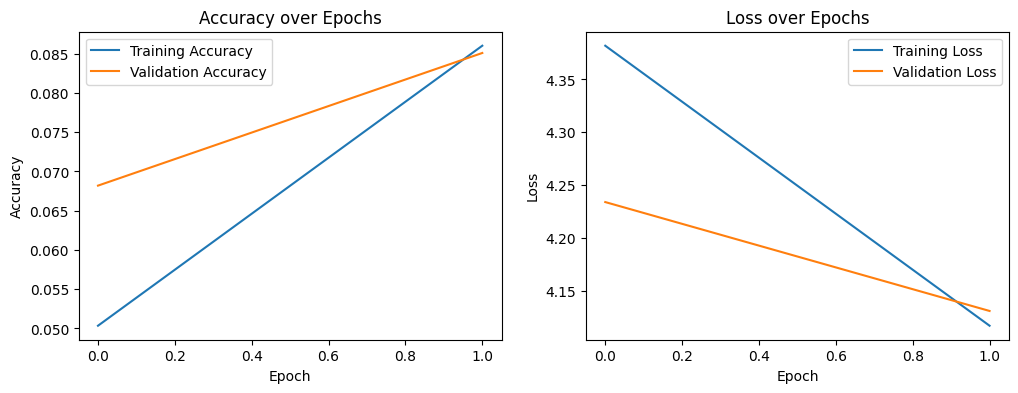

Accuracy: 9.0%
Loss: 4.13


In [71]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(
    f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
    f'Loss: {round(test_loss, 2)}'    
)